In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.special import erf

In [2]:
# For dealing with very large exponents, stolen from Wikipedia
def exp_by_squaring(x, pows):
    for n in pows:
        if n < 0:
            return exp_by_squaring(1 / x, -n);
        elif n == 0:
            return  1
        elif n == 1:
            return  x
        elif n is even:
            return exp_by_squaring(x * x,  n / 2)
        elif n is odd:
            return x * exp_by_squaring(x * x, (n - 1) / 2)

In [3]:
# probability from Eq. (20) in Epstein
def epstein_spherical_centre(k, delta):
    return (delta/(1+delta)) * exp_by_squaring((k/(1+delta)), k-1) * np.exp(-k/(1+delta)) / factorial(k-1)

# halo mass function from Inman \& Ali-Haimoud (2019):
def inman_ah(n, n_pbh, delta):
    return (n_pbh / n) * epstein_spherical_centre(n, delta)

# expression for N_*, given in Inman \& Ali-Haimoud (2019)
def n_star(delta):
    return 1 / (np.log(1+delta) - (delta / (1+delta)))

# discrete pdf from Press-Schechter formalism, from Hutsi, Veermae & Raidal (2019)
def press_schechter_discrete(n, delta):
    n_s = n_star(delta)
    return erf(np.sqrt(n/n_s)) - erf(np.sqrt((n-1)/n_s))

# continuous pdf from Press-Schechter formalism, from Hutsi, Veermae & Raidal (2019)
def press_schechter_continuous(n, delta):
    n_s = n_star(delta)
    return np.sqrt(n_s/n) * np.exp(-n/n_s)

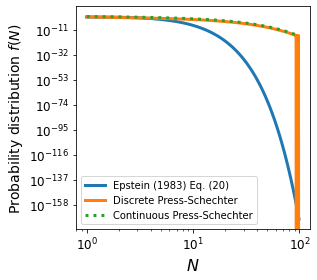

In [4]:
x = np.arange(1, 100)
delta = 1.686

fig = plt.figure(figsize=(4.5,4))
plt.plot(x, epstein_spherical_centre(x, delta), label='Epstein (1983) Eq. (20)', linewidth=3)
#plt.plot(x, inman_ah(x, 1., delta), label='Inman & Ali_Haïmoud (2019) Eq. (46)')
plt.plot(x, press_schechter_discrete(x, delta), label='Discrete Press-Schechter', linewidth=3)
plt.plot(x, press_schechter_continuous(x, delta), label='Continuous Press-Schechter', linewidth=3, linestyle=':')
plt.ylabel('Probability distribution $f(N)$', fontsize=14)
plt.xlabel('$N$', fontsize=16)
plt.xscale('log')
plt.yscale('log')

#plt.xlim(1, 110)
ax = fig.gca()
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend()
plt.tight_layout()
plt.savefig('fn.pdf')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 432x288 with 0 Axes>

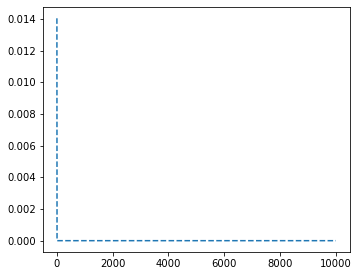

In [5]:
from scipy.optimize import fsolve

plt.clf()

# implicit equation to solve for kappa:
def f(kappa, params):
    delta, p_t = params
    return np.log(p_t/delta) + 0.5*np.log(2*kappa/np.pi) - kappa

def exp_by_squaring_singlevalue(x, n):
    if n < 0:
        return exp_by_squaring(1 / x, -n);
    elif n == 0:
        return  1
    elif n == 1:
        return  x
    elif n is even:
        return exp_by_squaring(x * x,  n / 2)
    elif n is odd:
        return x * exp_by_squaring(x * x, (n - 1) / 2)

# approximate - eq (38) of Epstein
def interior_prob_spherical_anywhere_approx(k, k_m, kappa):
    return 1 - np.exp(-np.sqrt(k/k_m) * np.exp( - kappa * (k/k_m - 1)))

def w(j, nu):
    return exp_by_squaring_singlevalue(nu, j) * np.exp(-nu) / factorial(j)

def f_ic(k, delta):
    nu_k = k/(1+delta)
    return w(k-1, nu_k)

def phi(k, delta):
    nu_k = k/(1+delta)
    return (nu_k + k - 1) / (1 + 1/( w(k-1, nu_k) ) )

# exact - eq (37) of Epstein
def interior_prob_spherical_anywhere(k, delta, p_t):
    nu_k = k/(1+delta)
    return 1 - (1 - f_ic(k, delta)) * np.exp(-phi(k, delta) * p_t)

# Epstein results
def epstein_spherical_anywhere(k, delta, p_t):
    
    # estimate for the input value of kappa
    est_kappa = np.log(p_t/delta)+1
    
    kappa = fsolve(f, est_kappa, args=([delta, p_t]))
    k_m = 2*kappa / delta **2
    f_ia = interior_prob_spherical_anywhere(k, k_m, kappa)
    
    kvals = np.arange(0, 100)
    
    avg_sum = 0
    for q in kvals:
        avg_sum += interior_prob_spherical_anywhere(kvals, k_m, kappa)
    f_ea = 1 / avg_sum
        
    return f_ia * f_ea

def epstein_spherical_anywhere_approx(k, delta, p_t):
    
    # estimate for the input value of kappa
    est_kappa = np.log(p_t/delta)+1
    
    kappa = est_kappa
    k_m = 2*kappa / delta **2
    f_ia = interior_prob_spherical_anywhere(k, k_m, kappa)
    
    kvals = np.arange(0, 100)
    for q in kvals:
        avg_sum += interior_prob_spherical_anywhere(kvals, k_m, kappa)
    f_ea = 1 / avg_sum

    #f_ea = 1 / k_m
        
    return f_ia * f_ea



def epstein_non_spherical_anywhere(k, delta, eta):
    return(epstein_spherical_anywhere(k, delta, (8*eta**3 - 1)))


x = np.arange(2, 10000)
p_t = 7
eta = 1.5

pows = (0., -0.5, -1, -3/2, -2)
pows = (0., -0.5, -1)


fig = plt.figure(figsize=(5.5,4.5))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, j in enumerate(pows):
    q = 10**j
    delta = 0.43 / q    # at z=999
    delta = 0.052 / q   # at z=99
    plt.plot(x, epstein_spherical_centre(x, delta), linestyle = '--', label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, epstein_spherical_anywhere(x, delta, p_t), label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, epstein_non_spherical_anywhere(x, delta, eta), linestyle = '-.', label='$f = 10$e{}'.format(j), color=colors[i])
    
    
plt.ylim(10**(-10), 1.)

plt.ylabel('Probability distribution $f(N)$', fontsize=14)
plt.xlabel('$N$', fontsize=16)
plt.xscale('log')
plt.yscale('log')


ax = fig.gca()
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend()
plt.tight_layout()
plt.savefig('fn_epstein.pdf')
plt.show()



fig2 = plt.figure(figsize=(5.5,4.5))

#get colour cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, j in enumerate(pows):
    q = 10**j
    delta = 0.43 / q    # at z=999
    delta = 0.052 / q   # at z=99
    #print('f', q)
    delta_N = x
    plt.plot(x, (10e5*q/x) * epstein_spherical_centre(x, delta) / delta_N, linestyle = '--', label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, (10e5*q/x) * epstein_spherical_anywhere_approx(x, delta, p_t) / delta_N, label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, (10e5*q/x) * epstein_non_spherical_anywhere(x, delta, eta) / delta_N, linestyle = '-.', label='$f = 10$e{}'.format(j), color=colors[i])    
    
plt.ylabel('$N_{HL}(N)$', fontsize=16)
plt.xlabel('$N$', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**(-2), 10**4)

ax = fig.gca()
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend()
plt.tight_layout()
plt.savefig('n_epstein.pdf')


In [49]:
# Maximum number of digits in 
# output
MAX=100000
 
# This function multiplies x
# with the number represented by res[].
# res_size is size of res[] or
# number of digits in the number
# represented by res[]. This function
# uses simple school mathematics
# for multiplication.
# This function may value of res_size
# and returns the new value of res_size
def multiply(x, res, res_size):
    # Initialize carry
    carry = 0
 
    # One by one multiply n with
    # individual digits of res[]
    for i in range(res_size):
        prod = res[i] * x + carry
        # Store last digit of
        # 'prod' in res[]
        res[i] = prod % 10
        # Put rest in carry
        carry = prod // 10

    # Put carry in res and
    # increase result size
    while (carry):
        res[res_size] = carry % 10
        carry = carry // 10
        res_size+=1
    
    return res_size
 
    
# This function finds power of a number x
def power(x,n):
    
    # printing value "1" for power = 0
    if (n == 0) : 
        print("1")
        return
    res = [0 for i in range(MAX)]
    res_size = 0
    temp = x
    
    # Initialise result
    while (temp != 0):
        res[res_size] = temp % 10;
        res_size += 1
        temp = temp // 10
        
    # Multiply x n times (x^n = x*x*x... n times)
    for i in range(2, n+1):
        res_size = multiply(x, res, res_size)
        
    return res
        
# Driver program
 
exponent = 100
base = 2
print(power(base, exponent))
 
# This code is contributed
# by Anant Agarwal.

[6, 7, 3, 5, 0, 2, 3, 0, 7, 6, 9, 4, 1, 0, 4, 9, 2, 2, 8, 2, 2, 0, 0, 6, 0, 5, 6, 7, 6, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

exponents  [array([1., 1., 1., ..., 1., 1., 1.])]


ValueError: setting an array element with a sequence.

<Figure size 432x288 with 0 Axes>

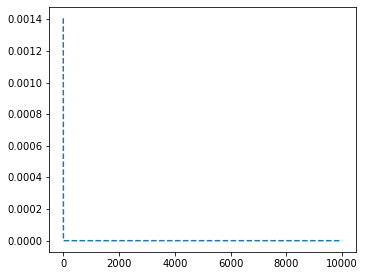

In [137]:
 # try writing everything using exponents that can take arrays
from scipy.optimize import fsolve
plt.clf()

# n is an integer
def power_by_squaring(x, n):
    if n < 0:
        return power_by_squaring(1 / x, -n);
    elif n == 0:
        return 1
    elif n == 1:
        return x
    elif n % 2 == 0:
        return power_by_squaring(x * x,  n / 2)
    else:
        return x * power_by_squaring(x * x, (n - 1) / 2)

# n is an integer    
def powers_onepower(x, n):
    exponents = np.zeros(len(x))
    for i, val in enumerate(x):
        exponents[i] = power_by_squaring(val, n)
    print('exponents ', [exponents])
    return [exponents]

# pows is an array of integers n
def powers(x, pows):
    pows = np.zeros(len(pows))
    for i, n in enumerate(pows):
        pows[i] = powers_onepower(x, n)
    print('pows ', pows)
    return pows

# implicit equation to solve for kappa:
def f(kappa, params):
    delta, p_t = params
    return np.log(p_t/delta) + 0.5*np.log(2*kappa/np.pi) - kappa

# approximate - eq (38) of Epstein
def interior_prob_spherical_anywhere_approx(k, k_m, kappa):
    return 1 - np.exp(-np.sqrt(k/k_m) * np.exp( - kappa * (k/k_m - 1)))


# Epstein results, approximate assuming large k, small delta
def epstein_spherical_anywhere_approx(k, delta, p_t):
    
    # estimate for the input value of kappa
    est_kappa = np.log(p_t/delta)+1
    
    kappa = fsolve(f, est_kappa, args=([delta, p_t]))
    k_m = 2*kappa / delta **2
    f_ia = interior_prob_spherical_anywhere_approx(k, k_m, est_kappa)
    
    kvals = np.arange(1, 1000)
    f_ea = 1 / np.sum(interior_prob_spherical_anywhere(kvals, k_m, est_kappa))
        
    return f_ia * f_ea


def w(j, nu):
    #print(j)
    #print('nu (w) = ', nu[1])
    #print('W = ', powers(nu, j) * np.exp(-nu) / factorial(j))
    return powers(nu, j) * np.exp(-nu) / factorial(j)

def f_ic(k, delta):
    #print(k)
    nu_k = k/(1+delta)
    #print('nu_k (f_ic) = ', nu_k[1])
    return w(k-1, nu_k)

def phi(k, delta):
    #print(k)
    #print('delta = ', delta)
    nu_k = k/(1+delta)
    #print('nu_k (phi) = ', nu_k[1])
    return w(k-1, nu_k) * (nu_k + k - 1) / (1 + w(k-1, nu_k))

# exact - eq (37) of Epstein
def interior_prob_spherical_anywhere(k, delta, p_t):
    #print(k)
    nu_k = k/(1+delta)
    return 1 - (1 - f_ic(k, delta)) * np.exp(-phi(k, delta) * p_t)

# Epstein results
def epstein_spherical_anywhere(k, delta, p_t):
    f_ia = interior_prob_spherical_anywhere(k, delta, p_t)
    
    kvals = np.arange(1, 1000)
    f_ea = 1 / np.sum(interior_prob_spherical_anywhere(kvals, delta, p_t))
        
    return f_ia * f_ea


def epstein_non_spherical_anywhere(k, delta, eta):
    return(epstein_spherical_anywhere(k, delta, (8*eta**3 - 1)))


x = np.arange(2, 10000)
p_t = 7
eta = 1.5

pows = (0., -0.5, -1, -3/2, -2)
pows = (0., -0.5, -1)


fig = plt.figure(figsize=(5.5,4.5))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, j in enumerate(pows):
    q = 10**j
    delta = 0.43 / q    # at z=999
    delta = 0.0052   # at z=99
    plt.plot(x, epstein_spherical_centre(x, delta), linestyle = '--', label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, epstein_spherical_anywhere(x, delta, p_t), label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, epstein_non_spherical_anywhere(x, delta, eta), linestyle = '-.', label='$f = 10$e{}'.format(j), color=colors[i])
    
    
#plt.ylim(10**(-10), 1.)

plt.ylabel('Probability distribution $f(N)$', fontsize=14)
plt.xlabel('$N$', fontsize=16)
plt.xscale('log')
plt.yscale('log')


ax = fig.gca()
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend()
plt.tight_layout()
plt.savefig('fn_epstein.pdf')
plt.show()



fig2 = plt.figure(figsize=(5.5,4.5))

#get colour cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, j in enumerate(pows):
    q = 10**j
    delta = 0.43 / q    # at z=999
    delta = 0.0052 / q  # at z=99
    #print('f', q)
    delta_N = x
    plt.plot(x, (10e5*q/x) * epstein_spherical_centre(x, delta) / delta_N, linestyle = '--', label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, (10e5*q/x) * epstein_spherical_anywhere(x, delta, p_t) / delta_N, label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, (10e5*q/x) * epstein_spherical_anywhere_approx(x, delta, p_t) / delta_N, linestyle = '-.', label='$f = 10$e{}'.format(j), color=colors[i])    
    
plt.ylabel('$N_{HL}(N)$', fontsize=16)
plt.xlabel('$N$', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**(-2), 10**4)

ax = fig.gca()
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend()
plt.tight_layout()
plt.savefig('n_epstein.pdf')


In [131]:
a = np.array([3])
for q in a:
    print(q)

vals = np.arange(1, 25)
print(vals)
for val in vals:
    print(powers_onepower(np.array([2]), val))

3
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[2.]
[4.]
[8.]
[16.]
[32.]
[64.]
[128.]
[256.]
[512.]
[1024.]
[2048.]
[4096.]
[8192.]
[16384.]
[32768.]
[65536.]
[131072.]
[262144.]
[524288.]
[1048576.]
[2097152.]
[4194304.]
[8388608.]
[16777216.]
